# Regresión Logística y MANOVA

>Este tutorial es una selección y adaptación al español de los libros [Multivariate Data Analysis](https://www.cengage.co.uk/books/9781473756540/) de Joseph F. Hair et al. y [Applied Regression Analysis & Generalized Linear Models](https://socialsciences.mcmaster.ca/jfox/Books/Applied-Regression-3E/index.html) de John Fox.


## Regresión Logística

La regresión logística es el modelo de regresión apropiado cuando la variable dependiente es una variable categórica (nominal o no métrica) y las variables independientes son métricas o no métricas. 

Es particularmente útil para tareas de clasificación. 

### Nociones previas

En una regresión logística, los coeficientes estimados para las variables independientes se estiman utilizando el valor logit como medida dependiente para garantizar que cualquier valor predicho (es decir, cualquier valor logit) se pueda transformar nuevamente en una probabilidad que se encuentre entre cero y uno. 

La formulación del modelo es:

$$ Logit_{i} = ln \left (  \frac{P_{event}}{1 - P_{event}} \right )  = b_{0} + b_{1} X_{1} + ... + b_{n} X_{n}  $$

A diferencia del modelo de regresión múltiple, la regresión logística utiliza el estimador de máxima verosimilitud (MLE). Esto quiere decir que en lugar de minimizar las desviaciones cuadradas (mínimos cuadrados), la regresión logística maximiza la verosimilitud de que ocurra un evento. 

>Nota: La verosimilitud es una medida diferente a la probabilidad. Refiere a qué tan "verosimil" es que los datos observados ocurran a partir de una parametrización determinada. 

Para ello, se vale de una medida relacionada, el doble del logaritmo negativo de la verosimilutd (- 2 log likelihood: -2LL). Esto debido a que esta función es más fácil de minimizar y, por tanto, hallar el valor máximo de la verosimilitud. 

Para calcular el ajuste general del modelo, se emplea la medida pseudo $R^{2}$, que se interpreta de manera similar al coeficiente de determinación en regresión múltiple. 

El pseudo $R^{2}$ para un modelo logit ($R^{2}_{Logit}$) se puede calcular como:

$$ R^{2}_{Logit} = \frac{-2LL_{null} - (- 2LL_{model}) }{- 2LL_{null}} $$

Podemos encontrar otras equivalencias con el modelo de regresión múltiple:

| Regresión Múltiple | Regresión Logística                              |
|--------------------|--------------------------------------------------|
| $SS_{total}$       | $-2LL_{null}$                                    |
| $SS_{error}$       | $-2LL_{model}$                                   |
| $SS_{model}$       | $2LL_{model} -2LL_{null}$                        |
| Prueba F           | Prueba Chi-cuadrado de $2LL_{model} -2LL_{null}$ |
| $R^{2}$            | Pseudo $R^{2}$                                   |

### Diseño

#### Codificación de la variable dependiente binaria

Los dos grupos de interés en la regresión logística se representan como variables binarias con valores de 0 y 1. No importa a qué grupo se le asigna el valor de 1 versus 0, pero esta asignación (codificación) debe tenerse en cuenta para la interpretación de los coeficientes.

- Si los grupos representan características (por ejemplo, género), entonces a cualquiera de los grupos se le puede asignar el valor de 1 (por ejemplo, mujeres) y al otro grupo el valor de 0 (por ejemplo, hombres). En tal situación, los coeficientes reflejarían el impacto de la(s) variable(s) independiente(s) en la probabilidad de que la persona sea mujer (es decir, el grupo codificado como 1).
- Si los grupos representan resultados o eventos (por ejemplo, éxito o fracaso, compra o no compra), la asignación de los códigos de grupo también afecta la interpretación. Suponga que el grupo con éxito se codifica como 1, con el fracaso codificado como 0. Entonces, los coeficientes representan los impactos sobre la probabilidad de éxito.

#### Tamaño de muestra

El uso de máxima verosimilitud (MLE) requiere muestras más grandes de modo que, en igualdad de condiciones, la regresión logística requerirá un tamaño de muestra mayor que la regresión múltiple. Por ejemplo, Hosmer y Lemeshow recomiendan tamaños de muestra superiores a 400.

El tamaño de muestra recomendado para cada grupo es de al menos 10 observaciones por parámetro estimado. Esto es mucho mayor que la regresión múltiple, que tuvo un mínimo de cinco observaciones por parámetro, y eso fue para la muestra general, no el tamaño de la muestra para cada grupo, como se ve con la regresión logística.


Una última consideración entra en juego con el uso de variables independientes no métricas. Cuando se incluyen en el modelo, subdividen aún más la muestra en celdas creadas por la combinación de variables independientes dependientes y no métricas. 

Todas las frecuencias de celda deben ser mayores que 1 y una gran mayoría (75% o más) debe tener frecuencias mayores que 5. La presencia de celdas pequeñas o vacías puede hacer que el modelo logístico se vuelva inestable, reportando coeficientes logísticos y razones de probabilidad increíblemente grandes para variables independientes.

### Supuestos

Las ventajas de la regresión logística en comparación con la regresión múltiple se derivan en gran medida de la falta general de supuestos requeridos en un análisis de regresión logística. No requiere ninguna forma de distribución específica de las variables independientes ni heterocedasticidad. Sí requiere independencia de las observaciones y, si está presente, debe abordarse mediante algún tipo de enfoque jerárquico o de muestra agrupada.

Un supuesto inherente que debe abordarse es la linealidad de las variables independientes, especialmente las continuas, con el resultado (binario).  

Este supuesto se verifica con la **prueba de Box-Tidwell**.La prueba de Box-Tidwell verifica si la transformada logit es una función lineal del predictor, efectivamente agregando la transformada no lineal del predictor original como un término de interacción para probar si esta adición no hizo una mejor predicción.

Un valor p significativo en la prueba de Box-Tidwell significa que se viola el supuesto de linealidad. 

Veamos un ejemplo:

In [7]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

df = pd.read_csv("https://socialsciences.mcmaster.ca/jfox/Books/Applied-Regression-3E/datasets/Cowles.txt", sep=r'\s{1,}', engine='python')
df.dropna(inplace=True)
cowles_data = pd.get_dummies(df, drop_first = True)
cowles_data["neuroticism"] = cowles_data["neuroticism"] + 1
cowles_data

,neuroticism,extraversion,sex_male,volunteer_yes
1,17.0,13.0,0,0
2,9.0,14.0,1,0
3,6.0,16.0,1,0
4,9.0,20.0,0,0
5,10.0,19.0,1,0
...,...,...,...,...
1417,6.0,10.0,1,1
1418,9.0,4.0,0,1
1419,9.0,8.0,1,1
1420,20.0,20.0,0,1


In [32]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [5]:
%%R 
# install.packages("car")

NULL


In [95]:
%%R -i bw_data

library("car")
boxTidwell(formula = volunteer_yes ~ neuroticism + extraversion, 
           other.x = ~ sex_male,
           data = cowles_data)

             MLE of lambda Score Statistic (z) Pr(>|z|)  
neuroticism         24.554              1.4151  0.15705  
extraversion         1.936              1.7238  0.08474 .
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

iterations =  26 


En este caso no obtenemos valores significativos para los predictores `neuroticism` y `extraversion`. Por tanto, se cumple el supuesto de linealidad de las variables independientes con la dependiente.

### Estimación y evaluación del modelo

Al igual que en la regresión múltiple, podemos evaluar el ajuste de la estimación del modelo. Para ello examinamos el grado en el que las medidas de resultado coinciden con las probabilidades predichas:
- Las pruebas de significación del modelo se pueden realizar con una prueba de chi-cuadrado sobre las diferencias en los valores $-2LL$ entre dos modelos (por ejemplo, modelo estimado y modelo nulo).
- Las medidas de pseudo $R^{2}$ son comparables a las que se encuentran en la regresión múltiple, pero generalmente tienen valores más bajos.

Veamos el ajuste en nuestro ejemplo:

In [8]:
import statsmodels.formula.api as smf

model = smf.logit("volunteer_yes ~ extraversion + neuroticism + sex_male", data = cowles_data).fit()
model.summary()

Optimization terminated successfully.
         Current function value: 0.670676
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:          volunteer_yes   No. Observations:                 1421
Model:                          Logit   Df Residuals:                     1417
Method:                           MLE   Df Model:                            3
Date:                Mon, 08 Nov 2021   Pseudo R-squ.:                 0.01419
Time:                        15:25:08   Log-Likelihood:                -953.03
converged:                       True   LL-Null:                       -966.75
Covariance Type:            nonrobust   LLR p-value:                 4.750e-06
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -1.1229      0.256     -4.378      0.000      -1.625      -0.620
extraversion     0.0663      0.014      4.651      0.000       0.038       0.094
neuroticism      0.0064      0.011      0.560      0.575      -0.016       0.029
sex_male        -0.2352      0.111     -2.115      0.034      -0.453      -0.017
================================================================================
"""

Podemos apreciar que el modelo es estadísticamente significativo. Sin embargo, en términos prácticos vemos que el modelo no tiene un poder explicativo bajo ($R^{2}$ = 0.01).

Por otra parte, podemos evaluar el impacto de cada observación en el ajuste y los coeficientes del modelo:

- Ambos residuos (Pearson y desviación) reflejan diferencias estandarizadas entre probabilidades predichas y valor de resultado (0 y 1). Los valores superiores a 2 merecen mayor atención.

Veamos el impacto de cada observación en nuestro ejemplo:

/home/renato/.virtualenvs/statspsych/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'Deviance Residuals')

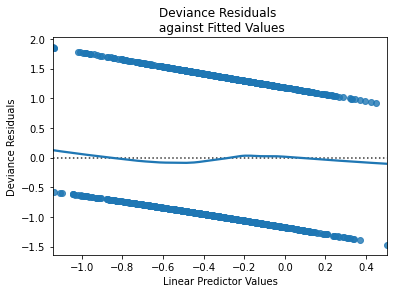

In [19]:
import statsmodels.api as sm
import seaborn as sns

ax = sns.residplot(model.fittedvalues,model.resid_dev, lowess=True);
ax.set_title("Deviance Residuals \n against Fitted Values")
ax.set_xlabel("Linear Predictor Values")
ax.set_ylabel("Deviance Residuals")

La linea continua se aproxima a cero, lo cual nos indica que no hay una inadecuación significativa del modelo. Además, podemos apreciar que los residuos no superan en valor absoluto a 2, por lo que no habría una observación influyente destacada. 

### Interpretación

#### Significancia de los coeficientes

Los valores altos de los coeficientes logísticos originales o los errores estándar asociados pueden indicar problemas de separación casi completos.

#### Interpretación de los coeficientes

Los coeficientes se expresan de dos formas: original y exponencial para ayudar en la interpretación. La interpretación de los coeficientes de dirección y magnitud es la siguiente:

- La dirección se puede evaluar directamente en los coeficientes originales (signos positivos o negativos).

- La magnitud se evalúa mejor mediante el coeficiente exponencial, con el cambio porcentual en la variable dependiente mostrado por:
$$ Cambio\ porcentual = (e^{coeficiente} - 1.0) \times 100 $$

Evaluemos los coeficientes en nuestro ejemplo:

In [24]:
import numpy as np
(np.exp(model.params) - 1) * 100

Intercept      -67.465145
extraversion     6.857438
neuroticism      0.638215
sex_male       -20.955677
dtype: float64

Podemos apreciar que el puntaje de extraversión aumenta en un 6% las posibilidades de que los individuos participen en el experimento. Del mismo modo, el ser varón reduce en un 20% las posibilidades de que un individuo participe en el experimento.

## MANOVA

MANOVA es una extensión de ANOVA que examina el efecto de una o más variables independientes no métricas sobre dos o más variables dependientes métricas.

El enfoque de MANOVA y ANOVA se encuentra típicamente en una única o muy pequeña cantidad de variables independientes (es decir, una relación de resultado de tratamiento específico) con todas las otras variables que impactan la relación de alguna manera.

Además de la capacidad de analizar múltiples variables dependientes, MANOVA también tiene las ventajas de:
- Controlar la tasa de error de todo el experimento cuando existe algún grado de intercorrelación entre las variables dependientes.
- Proporciona más poder estadístico que ANOVA cuando el número de variables dependientes es cinco o menos.
- Las variables independientes no métricas crean grupos entre los que se comparan las variables dependientes; muchas veces los grupos representan variables experimentales o "efectos del tratamiento".
- Los investigadores deben incluir solo variables dependientes que tengan un fuerte apoyo teórico.

#### MATH: ANOVA vs MANOVA simple. Foco en los estimadores. Basado en Hair.

### Diseño

Varios enfoques de investigación son aplicables al análisis ANOVA / MANOVA:
- Los diseños aleatorios, como los experimentos controlados y los experimentos de campo, están más estrechamente asociados con estas técnicas.
- Incluso los estudios observacionales proporcionan datos que pueden analizarse con técnicas especializadas para permitir inferencias válidas de efectos específicos.
- Los diseños no aleatorios, como los experimentos naturales y los cuasiexperimentos, aplican algunos de los principios del diseño experimental para centrarse en efectos específicos.

Si bien el enfoque principal está en el efecto principal (es decir, la relación entre el tratamiento / variable independiente y la variable dependiente / resultado), también se consideran variables y relaciones adicionales:
- Efectos explicativos adicionales como moderación y mediación.
- Control de influencias externas mediante covariables y factores de bloqueo.
- Variables externas como factores de confusión y variables instrumentales.

Las celdas (grupos) están formadas por la combinación de variables independientes; por ejemplo, una variable no métrica de tres categorías (por ejemplo, baja, media, alta) combinada con una variable no métrica de dos categorías (por ejemplo, género de hombre versus mujer) dará como resultado un diseño 3 3 2 con seis celdas (grupos).

El tamaño de la muestra por grupo es un problema de diseño crítico:
- El tamaño mínimo de la muestra por grupo debe ser mayor que el número de variables dependientes.
- El tamaño de celda mínimo recomendado es de 20 observaciones por celda (grupo).
- Los investigadores deben intentar tener diseños equilibrados (tamaños de muestra iguales por celda, es decir, grupo).

Los controles de manipulación proporcionan al investigador medidas objetivas del "éxito" de la manipulación y la percepción del tratamiento y también el grado en el que los encuestados siguen las instrucciones y mantienen el compromiso.

Las covariables y las variables de bloqueo son formas efectivas de controlar las influencias externas sobre las variables dependientes que no están directamente representadas en las variables independientes.
- Una covariable efectiva es aquella que está altamente correlacionada con la (s) variable (s) dependiente (s) pero no está correlacionada con las variables independientes.
- El número máximo de covariables en un modelo debe ser (.10 x tamaño de la muestra) - (Número de grupos - 1).



La mediación proporciona una explicación complementaria de "Por qué" podría ocurrir un efecto principal:
- Requiere un fuerte apoyo conceptual antes de cualquier prueba empírica
- El tipo de mediación (completa o parcial) se basa en la medida en que el efecto indirecto (es decir, la ruta causal a través del mediador) representa o es igual al efecto principal original.

La moderación aborda la validez externa en términos de si el efecto principal se generaliza a la población o debe verse como moderado (es decir, el efecto principal varía en fuerza y ​​/ o dirección según una tercera variable). Un ejemplo de moderación sería si el efecto principal variara según el género.

### Supuestos

Para que los procedimientos de prueba multivariados utilizados con MANOVA sean válidos:
- Las observaciones deben ser independientes.
- Las matrices de varianza-covarianza deben ser iguales (o comparables) para todos los grupos de tratamiento.
- Las variables dependientes deben tener una distribución normal multivariante.
- Se asume normalidad multivariante, pero muchas veces es difícil de evaluar; La normalidad univariada no garantiza la normalidad multivariada, pero si todas las variables cumplen con el requisito de normalidad univariante, las desviaciones de la normalidad multivariante son intrascendentes.

- Multivariate normality: data or residuals should have a multivariate normal distribution for each combination of independent and dependent variables (checked by Shapiro-Wilk test for univariate normality and Mardia’s skewness and kurtosis for multivariate normality)
- Homogeneity of the variance-covariance matrices: data should have equal variance-covariance matrices for each combination formed by each group in the independent variable. This is a multivariate version of the Homogeneity of variances that is checked in univariate ANOVA. It can be tested using Box’s M test. Box’s M-test has little power and uses a lower alpha level such as 0.001 to assess the p value for significance.
- Multicollinearity: There should be no multicollinearity (very high correlations i.e., > 0.9) among dependent variables

Las pruebas F son generalmente sólidas si las violaciones de estos supuestos son modestas.

Los valores atípicos pueden tener una influencia sustancial en los resultados y deben identificarse y potencialmente eliminarse.

In [163]:
df = pd.read_spss("HBAT.sav")
df = df[["x5","x19","x20","x21"]]
df['x5'] = df.x5.cat.codes
df.dropna(inplace=True)
df = df.astype('float')
df

,x5,x19,x20,x21
0,0.0,8.2,8.0,8.4
1,1.0,5.7,6.5,7.5
2,0.0,8.9,8.4,9.0
3,1.0,4.8,6.0,7.2
4,0.0,7.1,6.6,9.0
...,...,...,...,...
95,0.0,7.3,8.1,8.1
96,0.0,6.3,5.5,7.2
97,0.0,5.4,7.0,7.7
98,0.0,6.4,7.1,7.4


In [164]:
import pingouin as pg
pg.multivariate_normality(df[['x19','x20','x21']])

HZResults(hz=0.7414672119539445, pval=0.40794545422166156, normal=True)

In [165]:
pg.box_m(data = df, dvs=['x19','x20','x21'], group='x5')

,Chi2,df,pval,equal_cov
box,3.95595,6.0,0.682638,True


In [166]:
df[['x19','x20','x21']].corr()

,x19,x20,x21
x19,1.000000,0.764279,0.731049
x20,0.764279,1.000000,0.699923
x21,0.731049,0.699923,1.000000


In [170]:
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity

statistic, p_value = calculate_bartlett_sphericity(df[['x19','x20','x21']])
print("Chi-squared: ", statistic)
print("p-value: ", p_value)

Chi-squared:  173.02255896079998
p-value:  1.4079593963240545e-37


### Estimación y evaluación

#### Selección de una medida estadística
La medida preferida es la que es más inmune a las violaciones de los supuestos subyacentes a MANOVA y, sin embargo, mantiene el mayor poder. Cada medida se prefiere en diferentes situaciones:
- El criterio de Pillai o la lambda de Wilks es la medida preferida cuando se cumplen las consideraciones de diseño básicas (tamaño de muestra adecuado, sin violaciones de supuestos, tamaños de celda aproximadamente iguales).
- El criterio de Pillai se considera más sólido y debe usarse si el tamaño de la muestra disminuye, aparecen tamaños de celda desiguales o se viola la homogeneidad de las covarianzas.
- El gcr de Roy es una estadística de prueba más poderosa si el investigador está seguro de que todos los supuestos se cumplen estrictamente y las medidas dependientes son representativas de una sola dimensión de efectos.

En la gran mayoría de las situaciones, todas las medidas estadísticas proporcionan conclusiones similares.

Sin embargo, cuando se enfrentan a condiciones conflictivas, se pueden seleccionar medidas estadísticas que se ajusten a la situación que enfrenta el investigador.

#### Estimación MANOVA

Las cuatro medidas más utilizadas para evaluar la significancia estadística entre grupos en las variables independientes son:
- La raíz característica más grande de Roy
- Lambda de Wilks
- Criterio de Pillai
- T 2 de Hotelling.

En la mayoría de las situaciones, los resultados / conclusiones serán los mismos en las cuatro medidas, pero en algunos casos únicos los resultados diferirán entre las medidas.

Mantener un poder estadístico adecuado es fundamental:
- La potencia en el rango de .80 para el nivel alfa seleccionado es aceptable. El efecto indirecto debe calcularse y probarse con la prueba de Sobel o mediante procedimientos de arranque.
- Cuando el tamaño del efecto es pequeño, el investigador debe usar tamaños de muestra más grandes por grupo para mantener niveles aceptables de poder estadístico.

Si las medidas dependientes están muy correlacionadas (> .60), considere eliminar una o más medidas dependientes para reducir la colinealidad o utilice alguna forma de medida de resumen.

La mediación se estima ingresando al mediador como un efecto adicional al efecto principal.

La moderación se prueba como un efecto de interacción convencional del tratamiento con el moderador.

In [169]:
from statsmodels.multivariate.manova import MANOVA

maov = MANOVA.from_formula('x19 + x20 + x21 ~ x5', data=df)
print(maov.mv_test())

                   Multivariate linear model
                                                               
---------------------------------------------------------------
       Intercept         Value  Num DF  Den DF  F Value  Pr > F
---------------------------------------------------------------
          Wilks' lambda  0.0227 3.0000 96.0000 1375.4664 0.0000
         Pillai's trace  0.9773 3.0000 96.0000 1375.4664 0.0000
 Hotelling-Lawley trace 42.9833 3.0000 96.0000 1375.4664 0.0000
    Roy's greatest root 42.9833 3.0000 96.0000 1375.4664 0.0000
---------------------------------------------------------------
                                                               
---------------------------------------------------------------
              x5           Value  Num DF  Den DF F Value Pr > F
---------------------------------------------------------------
             Wilks' lambda 0.7227 3.0000 96.0000 12.2769 0.0000
            Pillai's trace 0.2773 3.0000 96.0000 12.2769 0.

#### Interpretación

##### Covariables

Cuando hay covariables involucradas en un modelo MANOVA:
- Analizar el modelo con y sin covariables.
- Si las covariables no mejoran el poder estadístico o no tienen ningún efecto sobre la significancia de los efectos del tratamiento, entonces pueden descartarse del análisis final.

Siempre que se incluyan en el análisis dos o más variables independientes (tratamientos), se deben examinar las interacciones antes de sacar conclusiones sobre los efectos principales de cualquier variable independiente.
- Si las interacciones no son estadísticamente significativas, los efectos principales se pueden interpretar directamente porque la diferencia entre tratamientos se considera constante en todas las combinaciones de niveles.
- Si la interacción es estadísticamente significativa y las diferencias no son constantes entre combinaciones de niveles, entonces la interacción debe determinarse como ordinal o desordinal.
- Las interacciones ordinales significan que la dirección de las diferencias no varía según el nivel (por ejemplo, los hombres siempre menos que las mujeres), aunque la diferencia entre hombres / mujeres varía según el nivel en el otro tratamiento; en este caso, la magnitud del efecto principal (p. ej., hombres frente a mujeres) solo debe describirse por separado para cada nivel del otro tratamiento.
- Se producen interacciones desordenadas significativas cuando la dirección de un efecto principal observado cambia con el nivel de otro tratamiento (por ejemplo, hombres más que mujeres para un nivel y menos que mujeres para otro nivel); las interacciones desordenadas interfieren con la interpretación de los efectos principales.

#### Diferencias entre grupos y resultados individuales

Cuando la variable independiente tiene más de dos grupos, se pueden utilizar dos tipos de procedimientos para aislar la fuente de las diferencias:
- Las pruebas post hoc examinan las posibles diferencias estadísticas entre todas las posibles combinaciones de medias de grupo; Las pruebas post hoc tienen una potencia limitada y, por lo tanto, son las más adecuadas para identificar grandes efectos.
- Las comparaciones planificadas son apropiadas cuando razones teóricas a priori sugieren que ciertos grupos diferirán de otro grupo o de otros grupos; El error de tipo I aumenta a medida que aumenta el número de comparaciones planificadas.

Dado que las pruebas multivariadas solo abordan las diferencias del conjunto colectivo de variables dependientes, los investigadores también deben examinar si esas diferencias se encuentran para cada variable dependiente por separado.
- La prueba más utilizada es el ANOVA univariante para cada medida dependiente
- El análisis discriminante puede proporcionar información sobre las dimensiones de las diferencias, especialmente si hay más de dos grupos.
- El análisis escalonado es un análisis poderoso si se conoce el orden causal de las variables dependientes.

#### Mediación y moderación

La mediación está representada por el efecto indirecto formado a partir de dos vías causales: tratamiento S mediador y mediador S resultado.
- El efecto indirecto representa el "por qué" detrás de un efecto principal al proporcionar un constructo (es decir, el mediador) a través del cual el tratamiento opera para crear el efecto en el resultado.
- La mediación completa se produce cuando el efecto de mediación (efecto indirecto) explica totalmente el efecto principal original.
- La mediación parcial se produce cuando el efecto indirecto es significativo, pero sigue existiendo un efecto principal significativo incluso después de contabilizar el efecto indirecto.

La moderación ocurre cuando el efecto principal varía según los diferentes valores del moderador.
- Un ejemplo sería que el efecto principal es diferente entre hombres y mujeres.
- Los efectos moderadores significativos exhiben patrones comparables a interacciones significativas (por ejemplo, líneas no paralelas)